# Python statsmodels for SARIMAX

This code is based on code from here: https://github.com/spierre91/builtiin/blob/main/time_series_forecasting.py

Some problems have been fixed. 

This current code base is not intended to be public or shared beyond ourselves.

In [16]:
!pip install seaborn pandas yfinance pandas_datareader statsmodels scikit-learn


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


### Import dependencies and set up

In [17]:
import pandas as pd 
import pandas_datareader as web 
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA


import pandas as pd
import yfinance as yf


import numpy as np
from sklearn.metrics import mean_squared_error




In [18]:

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

sns.set_theme()

### Let's get some sample time-series data that we need

In [19]:

btc = yf.download("AAPL", start='2018-01-01', end='2020-12-02')
btc['BTC-USD'] = btc['Close']
btc = btc[['BTC-USD']]
# btc = btc[['BTC-USD']].asfreq('M', method='bfill')



[*********************100%***********************]  1 of 1 completed


In [20]:
btc.head()

Price,BTC-USD
Ticker,
Date,
2018-01-02 00:00:00+00:00,43.064999
2018-01-03 00:00:00+00:00,43.057499
2018-01-04 00:00:00+00:00,43.257500
2018-01-05 00:00:00+00:00,43.750000
2018-01-08 00:00:00+00:00,43.587502


### Let's split the dataset for back testing.

In [21]:
train = btc[btc.index < pd.to_datetime("2020-11-01", format='%Y-%m-%d').tz_localize('UTC')] 
test = btc[btc.index >= pd.to_datetime("2020-11-01", format='%Y-%m-%d').tz_localize('UTC')]


In [22]:
train.head()

Price,BTC-USD
Ticker,
Date,
2018-01-02 00:00:00+00:00,43.064999
2018-01-03 00:00:00+00:00,43.057499
2018-01-04 00:00:00+00:00,43.257500
2018-01-05 00:00:00+00:00,43.750000
2018-01-08 00:00:00+00:00,43.587502


In [23]:
test.head()

Price,BTC-USD
Ticker,
Date,
2020-11-02 00:00:00+00:00,108.769997
2020-11-03 00:00:00+00:00,110.440002
2020-11-04 00:00:00+00:00,114.949997
2020-11-05 00:00:00+00:00,119.029999
2020-11-06 00:00:00+00:00,118.690002


### Let's plot train and test data

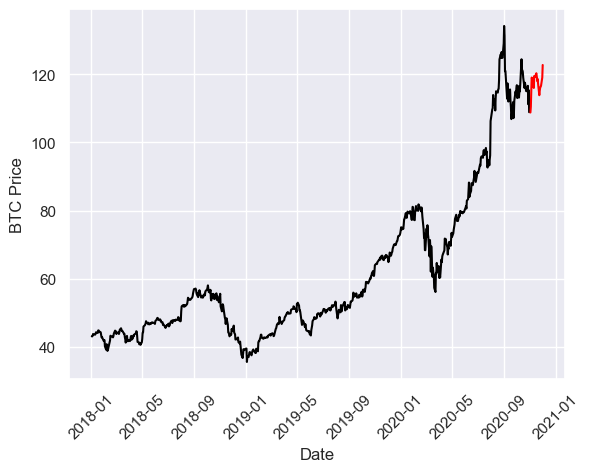

In [24]:

plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.plot(train, color='black', label='Training')
plt.plot(test, color='red', label='Test')
plt.show()



## Train and test an ARMA model 
(autoregressive + moving average - no differencing)

In [25]:

y = train['BTC-USD']

ARMAmodel = SARIMAX(y, order = (1, 0, 1)) # AR with 1 lookback, 0 differencing, and MA with 1 lookback
ARMAmodel = ARMAmodel.fit()

y_pred = ARMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_arma = y_pred_df["Predictions"] 

arma_rmse = np.sqrt(mean_squared_error(test["BTC-USD"].values, y_pred_df["Predictions"]))
print(f"\n\n\nARMA RMSE: {arma_rmse}\n\n\n")



/Users/damien/Desktop/DaemonDriveSyncMac/Olsam/forecast-example/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/damien/Desktop/DaemonDriveSyncMac/Olsam/forecast-example/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/damien/Desktop/DaemonDriveSyncMac/Olsam/forecast-example/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21148D+03    |proj g|=  2.77628D+03

At iterate    5    f=  8.94514D+00    |proj g|=  1.45147D+01

At iterate   10    f=  2.70873D+00    |proj g|=  5.65921D-01

At iterate   15    f=  2.07318D+00    |proj g|=  2.30746D-01

At iterate   20    f=  1.91557D+00    |proj g|=  2.80531D-02

At iterate   25    f=  1.89442D+00    |proj g|=  6.60542D-04

At iterate   30    f=  1.89259D+00    |proj g|=  4.78773D-03

At iterate   35    f=  1.89242D+00    |proj g|=  6.04298D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/damien/Desktop/DaemonDriveSyncMac/Olsam/forecast-example/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/damien/Desktop/DaemonDriveSyncMac/Olsam/forecast-example/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/damien/Desktop/DaemonDriveSyncMac/Olsam/forecast-example/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


### Let's plot the output

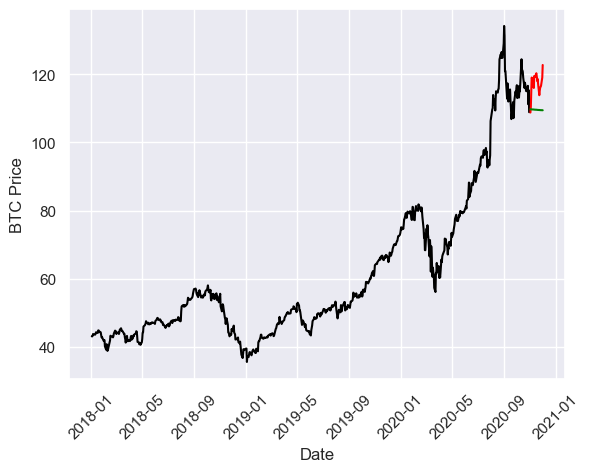

In [26]:

plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.plot(train, color='black', label='Training')
plt.plot(test, color='red', label='Test')
plt.plot(y_pred_arma, color='green', label = 'ARMA Predictions')
plt.show()

## Train and test an ARIMA model 
(autoregressive + moving average - now with differencing)

In [27]:
ARIMAmodel = ARIMA(y, order = (12, 1, 2)) # AR with 5 lookback, 1 differencing, and MA with 2 lookback
# ARIMAmodel = ARIMA(y, order = (7, 1, 4)) # AR with 7 lookback, 1 differencing, and MA with 4 lookback
# ARIMAmodel = ARIMA(y, order = (7, 2, 2)) # AR with 7 lookback, 2 differencing, and MA with 2 lookback
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_arima = y_pred_df["Predictions"] 

arma_rmse = np.sqrt(mean_squared_error(test["BTC-USD"].values, y_pred_df["Predictions"]))
print(f"\n\n\nARIMA RMSE: {arma_rmse}\n\n\n")

/Users/damien/Desktop/DaemonDriveSyncMac/Olsam/forecast-example/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/damien/Desktop/DaemonDriveSyncMac/Olsam/forecast-example/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/damien/Desktop/DaemonDriveSyncMac/Olsam/forecast-example/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)





ARIMA RMSE: 8.89992625837903





/Users/damien/Desktop/DaemonDriveSyncMac/Olsam/forecast-example/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/damien/Desktop/DaemonDriveSyncMac/Olsam/forecast-example/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/damien/Desktop/DaemonDriveSyncMac/Olsam/forecast-example/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


### Let's plot the output of the ARIMA

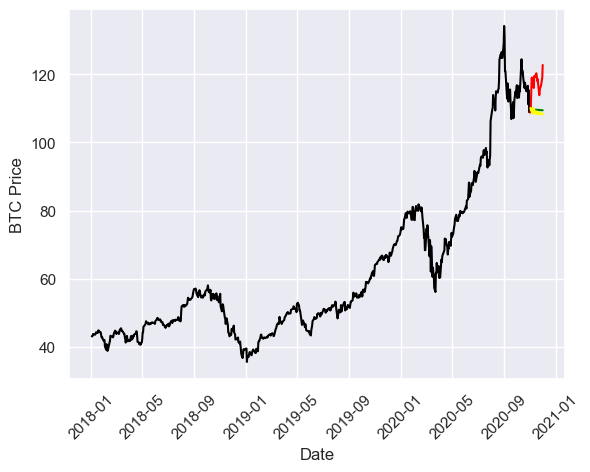

In [28]:

plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.plot(train, color='black', label='Training')
plt.plot(test, color='red', label='Test')
plt.plot(y_pred_arma, color='green', label = 'ARMA Predictions')
plt.plot(y_pred_arima, color='yellow', label = 'ARIMA Predictions')
plt.show()

## Let's add seasonality (SARIMA)

In [29]:

# SARIMAmodel = SARIMAX(y, order = (5, 4, 2), seasonal_order=(2,2,2,12))
SARIMAmodel = SARIMAX(y, order = (5, 1, 2), seasonal_order=(2,1,2,12)) # AR with 5 lookback, 4 differencing, and MA with 2 lookback, 12 month seasonality with AR of 2, differencing of 2, and MA of 2
#SARIMAmodel = SARIMAX(y, order = (5, 1, 2), seasonal_order=(2,1,2,365)) # AR with 5 lookback, 4 differencing, and MA with 2 lookback, 365 day seasonality with AR of 2, differencing of 2, and MA of 2
SARIMAmodel = SARIMAmodel.fit()

y_pred = SARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = SARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_sarimax = y_pred_df["Predictions"] 

arma_rmse = np.sqrt(mean_squared_error(test["BTC-USD"].values, y_pred_df["Predictions"]))
print(f"\n\n\nSARIMA RMSE: {arma_rmse}\n\n\n")

plt.show()

/Users/damien/Desktop/DaemonDriveSyncMac/Olsam/forecast-example/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/damien/Desktop/DaemonDriveSyncMac/Olsam/forecast-example/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/damien/Desktop/DaemonDriveSyncMac/Olsam/forecast-example/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/damien/Desktop/DaemonDriveSyncMac/Olsam/forecast-example/venv/lib/pytho

RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.


Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.97542D+00    |proj g|=  1.85532D-01

At iterate    5    f=  1.87345D+00    |proj g|=  2.75054D-02

At iterate   10    f=  1.86935D+00    |proj g|=  1.07257D-02

At iterate   15    f=  1.86209D+00    |proj g|=  1.05059D-02

At iterate   20    f=  1.85892D+00    |proj g|=  2.56566D-03

At iterate   25    f=  1.85878D+00    |proj g|=  3.68539D-04

At iterate   30    f=  1.85873D+00    |proj g|=  1.66137D-03

At iterate   35    f=  1.85871D+00    |proj g|=  1.61597D-04

At iterate   40    f=  1.85869D+00    |proj g|=  1.40181D-03

At iterate   45    f=  1.85864D+00    |proj g|=  2.78766D-03


/Users/damien/Desktop/DaemonDriveSyncMac/Olsam/forecast-example/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.85855D+00    |proj g|=  5.62574D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     56      1     0     0   5.626D-04   1.859D+00
  F =   1.8585486184053501     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 



SARIMA RMSE: 8.85066815772307





/Users/damien/Desktop/DaemonDriveSyncMac/Olsam/forecast-example/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/damien/Desktop/DaemonDriveSyncMac/Olsam/forecast-example/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/damien/Desktop/DaemonDriveSyncMac/Olsam/forecast-example/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


### Let's plot the output of SARIMA aganist the others

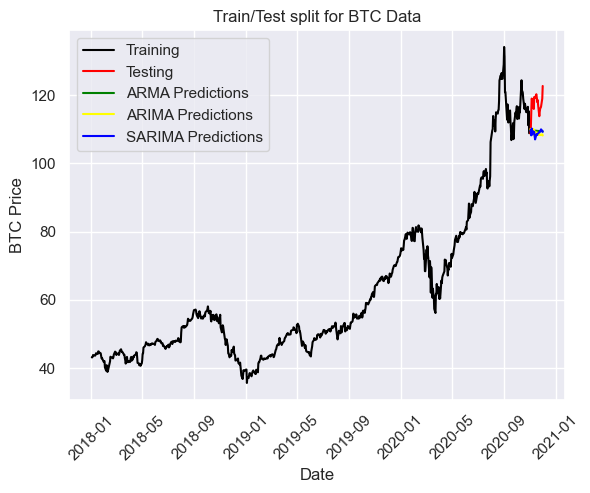

In [30]:
plt.plot(train, color = "black", label = 'Training')
plt.plot(test, color = "red", label = 'Testing')
plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for BTC Data")



plt.plot(y_pred_arma, color='green', label = 'ARMA Predictions')
plt.plot(y_pred_arima, color='yellow', label = 'ARIMA Predictions')
plt.plot(y_pred_sarimax, color='blue', label = 'SARIMA Predictions')
plt.legend()

plt.show()